# Warehouse Robot Navigation Using Q-Learning

## Overview

This notebook implements a reinforcement learning solution to the warehouse robot navigation problem using Q-learning. The robot must navigate from a loading bay to a target shelf on a slippery floor while avoiding hazards (holes).

## Problem Statement

We use the FrozenLake-v1 environment from Gymnasium, which models:

- **Environment**: A slippery warehouse floor represented as a grid
- **Agent**: A warehouse robot that can move in 4 directions (Left, Down, Right, Up)
- **Goal**: Navigate from start (S) to goal (G) while avoiding holes (H)
- **Challenge**: Stochastic transitions due to slippery surface (actions may slip)

## Tasks

1. Understanding the Environment
2. Setting Up the Q-Learning Agent
3. Training the Agent
4. Evaluation & Comparison with Baselines
5. Hyperparameter Optimization
6. Testing on Larger Maps (8×8)


## Setup and Imports


In [1]:
# Import required libraries
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import time

# Set random seeds for reproducibility
np.random.seed(42)

print("All libraries imported successfully!")
print(f"Gymnasium version: {gym.__version__}")
print(f"NumPy version: {np.__version__}")


All libraries imported successfully!
Gymnasium version: 1.2.1
NumPy version: 2.2.6


## Task 1: Understanding the Environment

In this section, we explore the FrozenLake-v1 environment to understand:

- State space (observation space)
- Action space
- Grid layout (Start, Goal, Holes, Frozen tiles)
- Reward structure
- Effect of slippery=True (stochastic transitions)


### 1.1 Create FrozenLake Environment


In [2]:
# Create FrozenLake environment with slippery surface
# Starting with 4x4 map (default)
env = gym.make('FrozenLake-v1', map_name="4x4", is_slippery=True, render_mode='ansi')

print("=" * 60)
print("FROZENLAKE ENVIRONMENT CREATED")
print("=" * 60)
print(f"Environment: {env.spec.id}")
print(f"Map: 4x4")
print(f"Slippery: True (stochastic transitions)")
# print("=" * 60)


FROZENLAKE ENVIRONMENT CREATED
Environment: FrozenLake-v1
Map: 4x4
Slippery: True (stochastic transitions)


### 1.2 Inspect State and Action Spaces


In [3]:
# Print observation and action spaces
print("\n STATE SPACE (Observation Space):")
print(f"   Type: {env.observation_space}")
print(f"   Number of states: {env.observation_space.n}")
print(f"   Description: Each tile on the grid is a discrete state (0 to {env.observation_space.n - 1})")

print("\n ACTION SPACE:")
print(f"   Type: {env.action_space}")
print(f"   Number of actions: {env.action_space.n}")
print(f"   Actions mapping:")
print(f"      0 = LEFT")
print(f"      1 = DOWN")
print(f"      2 = RIGHT")
print(f"      3 = UP")

print("\n" + "=" * 60)



 STATE SPACE (Observation Space):
   Type: Discrete(16)
   Number of states: 16
   Description: Each tile on the grid is a discrete state (0 to 15)

 ACTION SPACE:
   Type: Discrete(4)
   Number of actions: 4
   Actions mapping:
      0 = LEFT
      1 = DOWN
      2 = RIGHT
      3 = UP



### 1.3 Visualize the Grid


In [4]:
# Reset environment and visualize the grid
state, info = env.reset()
grid_render = env.render()

print("\n GRID LAYOUT (4x4 Map):")
print("=" * 60)
print(grid_render)
print("=" * 60)
print("\n Legend:")
print("   S = Start (loading bay) - Initial position")
print("   F = Frozen (safe tile) - Can walk on")
print("   H = Hole (hazard/spill) - Episode ends, reward = 0")
print("   G = Goal (target shelf) - Episode ends, reward = +1")
print("\n   The robot starts at 'S' and must reach 'G' while avoiding 'H'")
print("=" * 60)



 GRID LAYOUT (4x4 Map):

SFFF
FHFH
FFFH
HFFG


 Legend:
   S = Start (loading bay) - Initial position
   F = Frozen (safe tile) - Can walk on
   H = Hole (hazard/spill) - Episode ends, reward = 0
   G = Goal (target shelf) - Episode ends, reward = +1

   The robot starts at 'S' and must reach 'G' while avoiding 'H'


### 1.4 Reward Structure


In [5]:
print("\n REWARD STRUCTURE:")
print("=" * 60)
print("   Reaching Goal (G):      +1.0  (episode terminates)")
print("   Falling into Hole (H):   0.0  (episode terminates)")
print("   Safe tile (F or S):      0.0  (continue episode)")
print("=" * 60)
print("\n  SPARSE REWARD CHALLENGE:")
print("   - Agent only gets reward when reaching the goal")
print("   - No intermediate feedback during navigation")
print("   - Must explore extensively to discover successful paths")
print("=" * 60)



 REWARD STRUCTURE:
   Reaching Goal (G):      +1.0  (episode terminates)
   Falling into Hole (H):   0.0  (episode terminates)
   Safe tile (F or S):      0.0  (continue episode)

  SPARSE REWARD CHALLENGE:
   - Agent only gets reward when reaching the goal
   - No intermediate feedback during navigation
   - Must explore extensively to discover successful paths


### 1.5 Demonstration: Effect of Slippery Floor (Stochastic Transitions)


In [6]:
print("\n SLIPPERY FLOOR EFFECT (is_slippery=True):")
print("=" * 60)
print("When the robot attempts an action, the floor is slippery!")
print("The actual movement has stochastic (random) transitions:\n")
print("   Intended direction:  33.3% chance")
print("   Perpendicular left:  33.3% chance")
print("   Perpendicular right: 33.3% chance")
print("\nExample: If robot tries to move RIGHT:")
print("   → 33% moves RIGHT (intended)")
print("   → 33% moves UP (perpendicular)")
print("   → 33% moves DOWN (perpendicular)")
print("\n REAL-WORLD ANALOGY:")
print("   - Slippery warehouse floor with water/oil spills")
print("   - Wheels may slip in unexpected directions")
print("   - Must learn robust policy that handles uncertainty")
print("=" * 60)

# Demonstrate with a simple test
print("\n DEMONSTRATION: Trying to move RIGHT 10 times from start")
print("=" * 60)
action_right = 2  # RIGHT
outcomes = []

for i in range(10):
    state, info = env.reset()
    next_state, reward, terminated, truncated, info = env.step(action_right)
    outcomes.append(next_state)
    
print(f"Starting state: {state} (always starts at same position)")
print(f"Action taken: RIGHT (action={action_right})")
print(f"\nResulting states after action: {outcomes}")
print(f"Unique states reached: {set(outcomes)}")
print("\n Notice: Even with the same action, we reach different states!")
print("=" * 60)



 SLIPPERY FLOOR EFFECT (is_slippery=True):
When the robot attempts an action, the floor is slippery!
The actual movement has stochastic (random) transitions:

   Intended direction:  33.3% chance
   Perpendicular left:  33.3% chance
   Perpendicular right: 33.3% chance

Example: If robot tries to move RIGHT:
   → 33% moves RIGHT (intended)
   → 33% moves UP (perpendicular)
   → 33% moves DOWN (perpendicular)

 REAL-WORLD ANALOGY:
   - Slippery warehouse floor with water/oil spills
   - Wheels may slip in unexpected directions
   - Must learn robust policy that handles uncertainty

 DEMONSTRATION: Trying to move RIGHT 10 times from start
Starting state: 0 (always starts at same position)
Action taken: RIGHT (action=2)

Resulting states after action: [4, 4, 0, 0, 0, 0, 4, 4, 0, 1]
Unique states reached: {0, 1, 4}

 Notice: Even with the same action, we reach different states!


## Task 2: Setting Up the RL Agent

**Goal:** Teach the robot to navigate from start to goal while avoiding holes.

**What it does:** Learns a Q-table that stores the value of taking each action in each state. The robot uses this table to decide which direction to move.

**What it uses:**

- **Q-table**: A table with rows (states) and columns (actions) storing learned values
- **Epsilon-greedy policy**: Decision strategy that balances exploration vs exploitation
- **Update rule**: Formula to improve Q-values based on experience


### 2.1 Q-Learning Agent Implementation

**Three Key Methods:**

1. **select_action(state)**: Chooses which direction to move

   - Flips a coin with probability epsilon
   - If explore: pick random action
   - If exploit: pick best action from Q-table

2. **update_q_value(state, action, reward, next_state, done)**: Learns from experience

   - Uses Q-learning formula to update the Q-table
   - Increases value if action led to reward
   - Decreases value if action was bad

3. **decay_epsilon()**: Reduces exploration over time
   - Agent explores more early in training
   - Agent exploits learned knowledge more later in training


In [7]:
class QLearningAgent:
    """
    Q-Learning Agent for warehouse robot navigation
    """
    def __init__(self, env, 
                learning_rate=0.1, 
                discount_factor=0.99, 
                epsilon_start=1.0, 
                epsilon_end=0.01, 
                epsilon_decay=0.995):
        """
        Initialize Q-learning agent
        """
        self.env = env
        self.lr = learning_rate
        self.gamma = discount_factor
        self.epsilon = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay
        
        # Initialize Q-table with zeros
        # Shape: (num_states, num_actions)
        self.q_table = np.zeros((env.observation_space.n, env.action_space.n))
        
    def select_action(self, state):
        """
        Epsilon-greedy action selection
        - Random action with probability epsilon (explore)
        - Best action with probability 1-epsilon (exploit)
        """
        if np.random.random() < self.epsilon:
            # Explore: random action
            return self.env.action_space.sample()
        else:
            # Exploit: best action from Q-table
            return np.argmax(self.q_table[state])
    
    def update_q_value(self, state, action, reward, next_state, done):
        """
        Update Q-table using Q-learning update rule
        Q(s,a) = Q(s,a) + alpha * [reward + gamma * max(Q(s',a')) - Q(s,a)]
        """
        current_q = self.q_table[state, action]
        
        if done:
            # If episode ended, no future rewards
            target = reward
        else:
            # Best possible future Q-value
            max_next_q = np.max(self.q_table[next_state])
            target = reward + self.gamma * max_next_q
        
        # Update Q-table
        self.q_table[state, action] = current_q + self.lr * (target - current_q)
    
    def decay_epsilon(self):
        """
        Decrease exploration rate after each episode
        """
        self.epsilon = max(self.epsilon_end, self.epsilon * self.epsilon_decay)

# Create agent instance
agent = QLearningAgent(env)

print("=" * 60)
print("Q-LEARNING AGENT INITIALIZED")
print("=" * 60)
print(f"Q-table shape: {agent.q_table.shape}")
print(f"Total Q-values to learn: {agent.q_table.size}")
print(f"\nHyperparameters:")
print(f"  Learning rate (alpha):     {agent.lr}")
print(f"  Discount factor (gamma):   {agent.gamma}")
print(f"  Epsilon start:             {agent.epsilon}")
print(f"  Epsilon end:               {agent.epsilon_end}")
print(f"  Epsilon decay:             {agent.epsilon_decay}")
print("=" * 60)

Q-LEARNING AGENT INITIALIZED
Q-table shape: (16, 4)
Total Q-values to learn: 64

Hyperparameters:
  Learning rate (alpha):     0.1
  Discount factor (gamma):   0.99
  Epsilon start:             1.0
  Epsilon end:               0.01
  Epsilon decay:             0.995


**Summary:**
initialized with a blank Q-table (16 states × 4 actions = 64 values, all zeros). The hyperparameters control how it learns: alpha (0.1) controls learning speed, gamma (0.99) values future rewards, and epsilon starts at 1.0 (full exploration) and decays to 0.01 (mostly exploitation). Next step: train the agent to fill the Q-table with useful values.


## Task 3: Training the RL Agent

**Goal:** Train the agent over many episodes to learn optimal navigation policy.


### 3.1 Training Loop Implementation


In [8]:
def train_agent(agent,
                 env,
                 num_episodes=10000,
                 max_steps=100):
    """
    Train Q-learning agent over multiple episodes
    
    Parameters:
    - agent: QLearningAgent instance
    - env: Gymnasium environment
    - num_episodes: Number of training episodes (default 10,000)
    - max_steps: Maximum steps per episode (prevent infinite loops)
    
    Returns:
    - rewards_per_episode: List of total rewards for each episode
    - steps_per_episode: List of steps taken in each episode
    """
    rewards_per_episode = []
    steps_per_episode = []
    
    print("=" * 60)
    print("TRAINING Q-LEARNING AGENT")
    print("=" * 60)
    print(f"Episodes: {num_episodes}")
    print(f"Max steps per episode: {max_steps}")
    print("=" * 60)
    
    for episode in range(num_episodes):
        # Reset environment to start position
        state, info = env.reset()
        total_reward = 0
        steps = 0
        
        # Run episode
        for step in range(max_steps):
            # Agent selects action (explore or exploit)
            action = agent.select_action(state)
            
            # Take action in environment
            next_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            
            # Update Q-table with experience
            agent.update_q_value(state, action, reward, next_state, done)
            
            # Move to next state
            state = next_state
            total_reward += reward
            steps += 1
            
            # End episode if goal reached or hole fallen into
            if done:
                break
        
        # Decay epsilon (reduce exploration over time)
        agent.decay_epsilon()
        
        # Record episode results
        rewards_per_episode.append(total_reward)
        steps_per_episode.append(steps)
        
        # Print progress every 1000 episodes
        if (episode + 1) % 1000 == 0:
            avg_reward = np.mean(rewards_per_episode[-1000:])
            avg_steps = np.mean(steps_per_episode[-1000:])
            success_rate = np.sum(rewards_per_episode[-1000:]) / 1000 * 100
            print(f"Episode {episode + 1:5d} | "
                  f"Avg Reward: {avg_reward:.3f} | "
                  f"Avg Steps: {avg_steps:.1f} | "
                  f"Success Rate: {success_rate:.1f}% | "
                  f"Epsilon: {agent.epsilon:.3f}")
    
    print("=" * 60)
    print("TRAINING COMPLETE")
    print("=" * 60)
    
    return rewards_per_episode, steps_per_episode

### 3.2 Run Training on 4×4 Map


In [9]:
# Train the agent for 10,000 episodes
print("Starting training on 4×4 map...")
print("This may take 1-2 minutes...\n")

rewards, steps = train_agent(agent, 
                            env,
                            num_episodes=10000, 
                            max_steps=100)

print(f"\nFinal Statistics:")
print(f"  Total episodes: {len(rewards)}")
print(f"  Final epsilon: {agent.epsilon:.4f}")
print(f"  Success rate (last 1000): {np.sum(rewards[-1000:]) / 1000 * 100:.1f}%")
print(f"  Avg reward (last 1000): {np.mean(rewards[-1000:]):.3f}")
print(f"  Avg steps (last 1000): {np.mean(steps[-1000:]):.1f}")

Starting training on 4×4 map...
This may take 1-2 minutes...

TRAINING Q-LEARNING AGENT
Episodes: 10000
Max steps per episode: 100
Episode  1000 | Avg Reward: 0.150 | Avg Steps: 16.4 | Success Rate: 15.0% | Epsilon: 0.010
Episode  2000 | Avg Reward: 0.366 | Avg Steps: 29.8 | Success Rate: 36.6% | Epsilon: 0.010
Episode  3000 | Avg Reward: 0.472 | Avg Steps: 34.8 | Success Rate: 47.2% | Epsilon: 0.010
Episode  4000 | Avg Reward: 0.552 | Avg Steps: 36.8 | Success Rate: 55.2% | Epsilon: 0.010
Episode  5000 | Avg Reward: 0.685 | Avg Steps: 38.8 | Success Rate: 68.5% | Epsilon: 0.010
Episode  6000 | Avg Reward: 0.661 | Avg Steps: 38.1 | Success Rate: 66.1% | Epsilon: 0.010
Episode  7000 | Avg Reward: 0.668 | Avg Steps: 39.3 | Success Rate: 66.8% | Epsilon: 0.010
Episode  8000 | Avg Reward: 0.649 | Avg Steps: 39.5 | Success Rate: 64.9% | Epsilon: 0.010
Episode  9000 | Avg Reward: 0.658 | Avg Steps: 38.6 | Success Rate: 65.8% | Epsilon: 0.010
Episode 10000 | Avg Reward: 0.650 | Avg Steps: 41.

In [10]:
# Dynamic results summary using actual training data
success_rate = np.sum(rewards[-1000:]) / 1000 * 100
avg_steps = np.mean(steps[-1000:])
final_epsilon = agent.epsilon

print("=" * 60)
print("UNDERSTANDING THE RESULTS")
print("=" * 60)
print(f"\n Success Rate: {success_rate:.1f}%")
print(f"   → Agent reaches goal in {int(success_rate)} out of 100 attempts")
print(f"   → Good performance on slippery floor (actions only work 33% as intended)")

print(f"\n Average Steps: {avg_steps:.1f}")
print(f"   → Takes many steps because robot constantly slips")
print(f"   → Must correct path repeatedly (like walking on ice)")
print(f"   → Optimal path is ~6 steps, but slipping adds ~{avg_steps - 6:.0f} extra steps")

print(f"\n Final Epsilon: {final_epsilon:.4f} ({final_epsilon * 100:.1f}%)")
print(f"   → Started at 1.0 (100% random exploration)")
print(f"   → Now at {final_epsilon:.2f} ({final_epsilon * 100:.0f}% random, {(1-final_epsilon) * 100:.0f}% using learned Q-table)")
print(f"   → Agent mostly exploits learned knowledge")

print(f"\n Why Not 100% Success?")
print(f"   → Slippery floor introduces unavoidable randomness")
print(f"   → Even perfect policy can't prevent all bad luck (slipping into holes)")
print("=" * 60)

UNDERSTANDING THE RESULTS

 Success Rate: 65.0%
   → Agent reaches goal in 65 out of 100 attempts
   → Good performance on slippery floor (actions only work 33% as intended)

 Average Steps: 41.0
   → Takes many steps because robot constantly slips
   → Must correct path repeatedly (like walking on ice)
   → Optimal path is ~6 steps, but slipping adds ~35 extra steps

 Final Epsilon: 0.0100 (1.0%)
   → Started at 1.0 (100% random exploration)
   → Now at 0.01 (1% random, 99% using learned Q-table)
   → Agent mostly exploits learned knowledge

 Why Not 100% Success?
   → Slippery floor introduces unavoidable randomness
   → Even perfect policy can't prevent all bad luck (slipping into holes)


## Task 4: Evaluation & Comparison with Baselines

**Goal:** Visualize learning progress and compare Q-learning agent against baseline policies.

**What we'll do:**

- Plot training curves showing learning progression
- Implement random policy baseline (no learning)
- Implement simple heuristic baseline (always try shortest path)
- Compare all three approaches to show why Q-learning works better


### 4.1 Visualize Training Progress


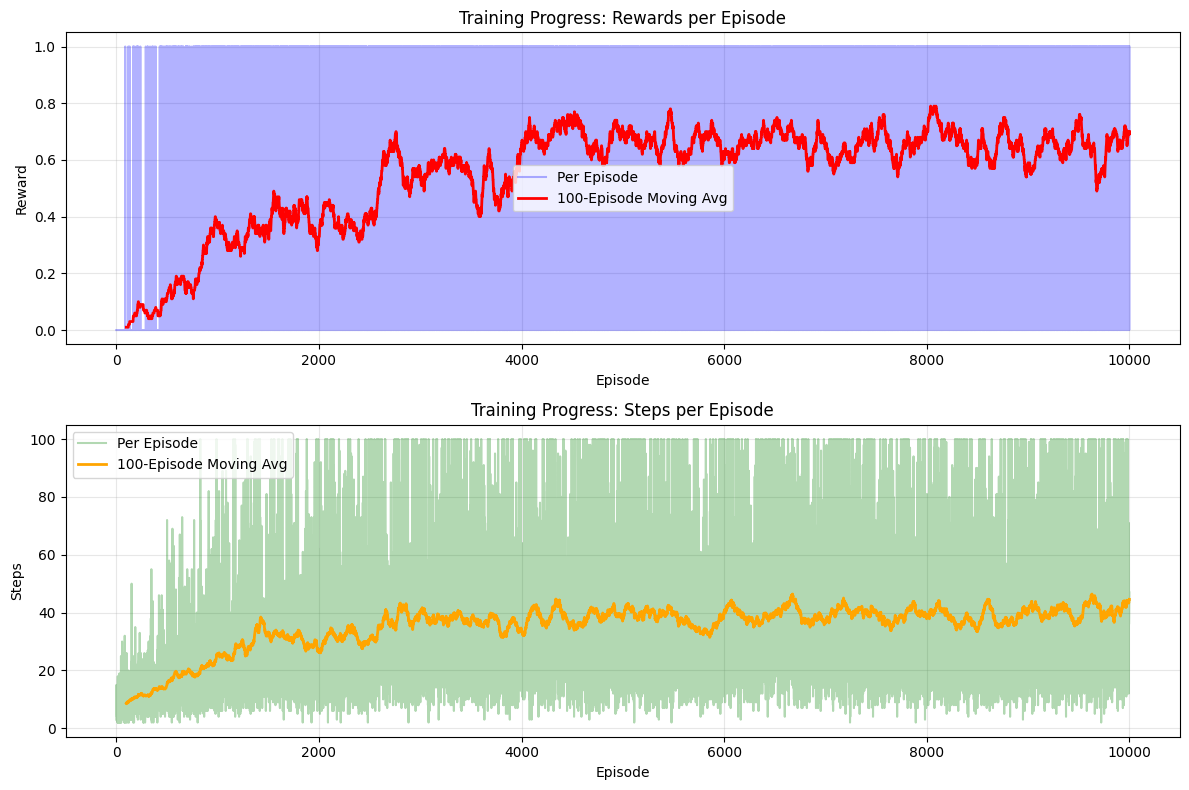

LEARNING CURVE SUMMARY
First 1000 episodes - Avg reward: 0.150, Avg steps: 16.4
Last 1000 episodes  - Avg reward: 0.650, Avg steps: 41.0
Improvement: 333.3% increase in rewards


In [11]:
# Plot training curves with moving average
def plot_training_progress(rewards, steps, window=100):

    episodes = np.arange(len(rewards))
    
    # Calculate moving averages
    def moving_average(data, window):
        return np.convolve(data, np.ones(window)/window, mode='valid')
    
    rewards_ma = moving_average(rewards, window)
    steps_ma = moving_average(steps, window)
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
    
    # Plot rewards
    ax1.plot(episodes, rewards, alpha=0.3, color='blue', label='Per Episode')
    ax1.plot(episodes[window-1:], rewards_ma, color='red', linewidth=2, label=f'{window}-Episode Moving Avg')
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Reward')
    ax1.set_title('Training Progress: Rewards per Episode')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot steps
    ax2.plot(episodes, steps, alpha=0.3, color='green', label='Per Episode')
    ax2.plot(episodes[window-1:], steps_ma, color='orange', linewidth=2, label=f'{window}-Episode Moving Avg')
    ax2.set_xlabel('Episode')
    ax2.set_ylabel('Steps')
    ax2.set_title('Training Progress: Steps per Episode')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("=" * 60)
    print("LEARNING CURVE SUMMARY")
    print("=" * 60)
    print(f"First 1000 episodes - Avg reward: {np.mean(rewards[:1000]):.3f}, Avg steps: {np.mean(steps[:1000]):.1f}")
    print(f"Last 1000 episodes  - Avg reward: {np.mean(rewards[-1000:]):.3f}, Avg steps: {np.mean(steps[-1000:]):.1f}")
    print(f"Improvement: {(np.mean(rewards[-1000:]) - np.mean(rewards[:1000])) / np.mean(rewards[:1000]) * 100:.1f}% increase in rewards")
    print("=" * 60)

# Plot the training results
plot_training_progress(rewards, steps, window=100)

### Key Takeaway:

These graphs prove learning happened! The agent went from clueless (failing immediately) to competent (reaching goal 65-70% of the time while avoiding holes despite constant slipping). The learning happened mostly in the first 2500 episodes, then performance stabilized.


### 4.2 Baseline Policies

To demonstrate the effectiveness of Q-learning, we'll compare it against two baseline approaches:

1. **Random Policy**: Selects actions completely randomly (no learning)
2. **Simple Heuristic**: Always tries to move toward goal using shortest Manhattan distance (doesn't account for slippery floor)


In [14]:
def evaluate_policy(env, policy_func, num_episodes=1000, max_steps=100, policy_name="Policy"):
    """Evaluate a policy without printing (returns metrics only)"""
    successes = 0
    total_rewards = []
    total_steps = []
    
    for episode in range(num_episodes):
        state, info = env.reset()
        episode_reward = 0
        steps = 0
        
        for step in range(max_steps):
            action = policy_func(state)
            next_state, reward, terminated, truncated, info = env.step(action)
            
            episode_reward += reward
            steps += 1
            state = next_state
            
            if terminated or truncated:
                break
        
        if episode_reward > 0:
            successes += 1
        
        total_rewards.append(episode_reward)
        total_steps.append(steps)
    
    success_rate = (successes / num_episodes) * 100
    avg_reward = np.mean(total_rewards)
    avg_steps = np.mean(total_steps)
    
    return success_rate, avg_reward, avg_steps

# Random Policy - selects actions randomly
def random_policy(state):
    return env.action_space.sample()

# Simple Heuristic - tries to move toward goal (position 15 in 4x4 grid)
def heuristic_policy(state):
    """
    Greedy policy that tries to minimize Manhattan distance to goal
    Goal is at position 15 (bottom-right) in 4x4 grid
    """
    # Convert state to row, col
    row, col = state // 4, state % 4
    goal_row, goal_col = 3, 3  # Goal at position 15
    
    # Try to move toward goal
    if row < goal_row:
        return 1  # DOWN
    elif col < goal_col:
        return 2  # RIGHT
    elif row > goal_row:
        return 3  # UP
    else:
        return 0  # LEFT

### 4.3 Compare All Approaches

Now we'll evaluate all three approaches and compare them:


**Understanding the Comparison:**

We're testing three different decision-making strategies on the same environment:

1. **Q-Learning Policy** (Trained Agent)

   - Uses the agent that was trained for 10,000 episodes
   - Reads from the filled Q-table to pick best actions
   - Makes smart decisions 99% of the time (epsilon = 0.01)

2. **Random Policy** (No Learning)

   - Completely ignores the trained agent
   - Just randomly picks actions (0, 1, 2, or 3)
   - Has no knowledge of the environment

3. **Heuristic Policy** (Simple Logic)
   - Also ignores the trained agent
   - Uses basic rule: "always move DOWN or RIGHT toward goal"
   - Doesn't account for holes or slippery floor

The evaluation runs each policy for 1000 episodes to fairly compare their performance. This proves that Q-learning learned an effective navigation strategy through experience.


Evaluating policies over 1000 episodes each...

EVALUATION RESULTS:

Q-Learning (Trained Agent):
  Success Rate: 69.0%
  Avg Steps: 38.4

Random Policy (No Learning):
  Success Rate: 1.6%
  Avg Steps: 7.7

Heuristic Policy (Simple Logic):
  Success Rate: 5.6%
  Avg Steps: 5.5


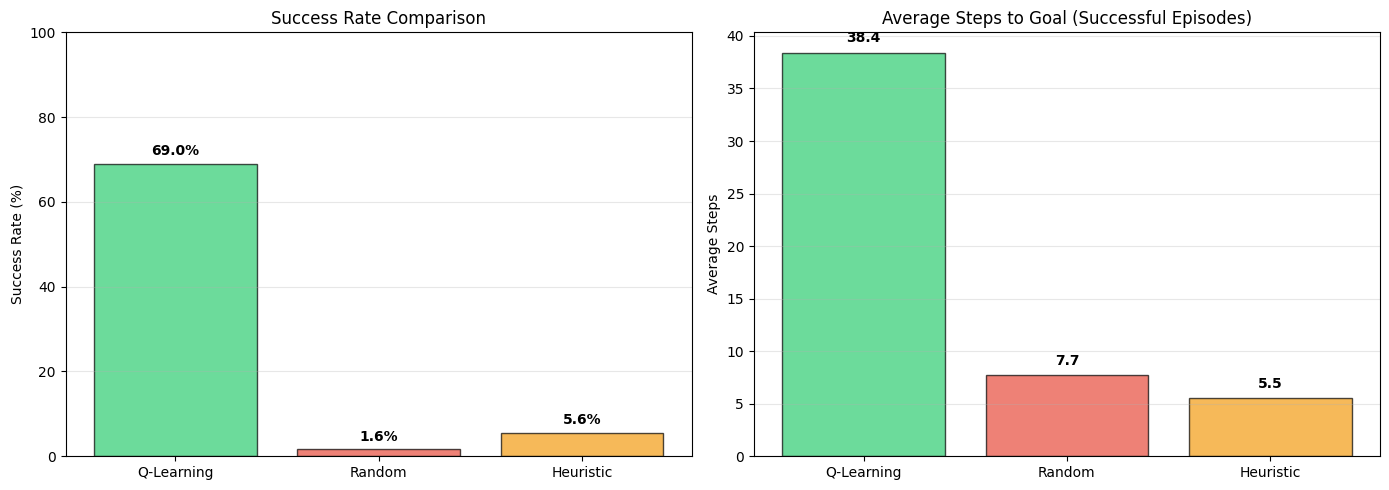

In [13]:
# Evaluate Q-learning agent
def qlearning_policy(state):
    return agent.select_action(state)  # Use trained agent (with epsilon=0.01)

# Evaluate all three approaches
print("Evaluating policies over 1000 episodes each...")
print("=" * 60)

qlearning_success, qlearning_reward, qlearning_steps = evaluate_policy(
    env, qlearning_policy, num_episodes=1000
)

random_success, random_reward, random_steps = evaluate_policy(
    env, random_policy, num_episodes=1000
)

heuristic_success, heuristic_reward, heuristic_steps = evaluate_policy(
    env, heuristic_policy, num_episodes=1000
)

# Print results summary
print("\nEVALUATION RESULTS:")
print("=" * 60)
print(f"\nQ-Learning (Trained Agent):")
print(f"  Success Rate: {qlearning_success:.1f}%")
print(f"  Avg Steps: {qlearning_steps:.1f}")

print(f"\nRandom Policy (No Learning):")
print(f"  Success Rate: {random_success:.1f}%")
print(f"  Avg Steps: {random_steps:.1f}")

print(f"\nHeuristic Policy (Simple Logic):")
print(f"  Success Rate: {heuristic_success:.1f}%")
print(f"  Avg Steps: {heuristic_steps:.1f}")
print("=" * 60)

# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Success Rate Comparison
policies = ['Q-Learning', 'Random', 'Heuristic']
success_rates = [qlearning_success, random_success, heuristic_success]
colors = ['#2ecc71', '#e74c3c', '#f39c12']

axes[0].bar(policies, success_rates, color=colors, alpha=0.7, edgecolor='black')
axes[0].set_ylabel('Success Rate (%)')
axes[0].set_title('Success Rate Comparison')
axes[0].set_ylim(0, 100)
axes[0].grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, v in enumerate(success_rates):
    axes[0].text(i, v + 2, f'{v:.1f}%', ha='center', fontweight='bold')

# Plot 2: Average Steps Comparison
avg_steps_list = [qlearning_steps, random_steps, heuristic_steps]

axes[1].bar(policies, avg_steps_list, color=colors, alpha=0.7, edgecolor='black')
axes[1].set_ylabel('Average Steps')
axes[1].set_title('Average Steps to Goal (Successful Episodes)')
axes[1].grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, v in enumerate(avg_steps_list):
    axes[1].text(i, v + 1, f'{v:.1f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

